### Autoreload

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
# Task models
from dlomix.models.chargestate import DominantChargeStatePredictor # Task 1
from dlomix.models.chargestate import ObservedChargeStatePredictor # Task 2
from dlomix.models.chargestate import ChargeStateProportionPredictor # Task 3

# Constants
from dlomix.constants import ALPHABET_UNMOD

# libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
import numpy as np 
import random
from scipy.spatial.distance import cosine
from scipy.stats import entropy
# 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import cosine
from scipy.stats import entropy
from tensorflow.keras.callbacks import Callback

# load model 
from tensorflow.keras.models import load_model

2024-06-07 15:42:08.397435: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 15:42:08.470151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 15:42:08.470170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 15:42:08.487603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 15:42:08.513023: I tensorflow/core/platform/cpu_feature_guar

## Create dummy data

In [3]:
# Set the random seeds
np.random.seed(42)
random.seed(42)

# Dummy Data Size
num_samples = 1000
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
min_seq_len = 5
max_seq_len = 20

# Generate random sequences
def generate_random_sequence(length):
    return "".join(random.choices(amino_acids, k=length))

dummy_sequences = [generate_random_sequence(random.randint(min_seq_len, max_seq_len)) for _ in range(num_samples)]

# Create dummy data
dummy_data = {
    'modified_sequence': dummy_sequences,
    'precursor_intensity': np.random.lognormal(mean=10, sigma=1, size=num_samples),
    'max_intensity': np.random.lognormal(mean=8, sigma=1.5, size=num_samples),
    'avg_intensity': np.random.lognormal(mean=8, sigma=1, size=num_samples),
    'precursor_charge': np.random.choice(['1', '2', '3', '4', '5', '6'], size=num_samples),
    'charge_by_max_intensity': np.random.randint(1, 6, size=num_samples),
    'charge_state_vector': [list(np.random.choice([0, 1], size=6)) for _ in range(num_samples)],
    'one_hot_most_abundant_charge': [list(np.eye(6)[np.random.randint(0, 6)]) for _ in range(num_samples)],
    'normalized_intensity_distribution': [list(np.random.dirichlet(np.ones(6))) for _ in range(num_samples)],
}

dummy_df = pd.DataFrame(dummy_data)
print(dummy_df.head())

    modified_sequence  precursor_intensity  max_intensity  avg_intensity  \
0            AGFRQVCK         36196.371320   24319.484879    1517.503342   
1               CFPNR         19182.155002   11931.658496    2579.836566   
2  FNTATQHEYHCCTPTRMY         42095.180602    3259.879645    1349.622333   
3   CGPVIECQSYVVILTEI        101015.561318    1129.572852    2190.835968   
4       RQCPMFLGWQFHS         17428.230714    8495.865993     448.713829   

  precursor_charge  charge_by_max_intensity charge_state_vector  \
0                6                        2  [1, 0, 0, 1, 0, 1]   
1                4                        5  [0, 1, 1, 0, 0, 1]   
2                2                        1  [1, 1, 0, 0, 0, 0]   
3                6                        1  [1, 1, 1, 1, 0, 1]   
4                1                        1  [1, 0, 0, 1, 0, 1]   

     one_hot_most_abundant_charge  \
0  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]   
1  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]   
2  [0.0, 0.0, 1.0, 0.0, 0.0, 

In [4]:
# encode the sequences
dummy_df.modified_sequence = dummy_df.modified_sequence.apply(list).apply(lambda x: np.array([ALPHABET_UNMOD[aa] for aa in x]))

In [5]:
# determine the maximum sequence length in the dummy-dataset
max_len = dummy_df.modified_sequence.apply(len).max()
max_len

20

In [6]:
# pad sequences to max length with 0s
dummy_df.modified_sequence = dummy_df.modified_sequence.apply(lambda x: np.pad(x, (0, max_len - len(x)), constant_values=0))

### Split dummy data

In [7]:
# Split the data into train, validation and test sets
dummy_train_df, dummy_test_df = train_test_split(dummy_df, test_size=0.2, stratify=dummy_df['precursor_charge'])
dummy_train_df, dummy_val_df = train_test_split(dummy_train_df, test_size=0.25, stratify=dummy_train_df['precursor_charge'])

# Check distribution of the stratified column
print(dummy_train_df['precursor_charge'].value_counts())
print(dummy_val_df['precursor_charge'].value_counts())
print(dummy_test_df['precursor_charge'].value_counts())

precursor_charge
4    109
6    108
3    102
5     98
2     98
1     85
Name: count, dtype: int64
precursor_charge
4    37
6    36
3    34
2    32
5    32
1    29
Name: count, dtype: int64
precursor_charge
4    36
6    36
3    34
5    33
2    32
1    29
Name: count, dtype: int64


In [8]:
dummy_train_df.head()

,modified_sequence,precursor_intensity,max_intensity,avg_intensity,precursor_charge,charge_by_max_intensity,charge_state_vector,one_hot_most_abundant_charge,normalized_intensity_distribution
4,"[15, 14, 2, 13, 11, 5, 10, 6, 19, 14, 5, 7, 16...",17428.230714,8495.865993,448.713829,1,1,"[1, 0, 0, 1, 0, 1]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.20629753240620344, 0.16707228468155383, 0.0..."
919,"[5, 13, 7, 15, 1, 9, 17, 0, 0, 0, 0, 0, 0, 0, ...",26744.656969,1468.305265,10892.957755,4,5,"[0, 1, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.21908741505324741, 0.08152975019136677, 0.0..."
471,"[14, 20, 18, 19, 8, 15, 17, 1, 20, 13, 17, 14,...",2204.109464,1194.312092,31693.677582,6,1,"[0, 0, 0, 1, 1, 0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.19002376067759677, 0.0588641505747201, 0.13..."
654,"[8, 13, 3, 19, 19, 18, 13, 4, 11, 12, 14, 4, 1...",288762.492297,4952.886244,1544.052058,6,3,"[1, 0, 1, 1, 0, 0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.18419068909704223, 0.13271286637116517, 0.0..."
518,"[2, 1, 10, 7, 10, 7, 8, 17, 17, 3, 3, 13, 16, ...",24326.761154,641.442639,2368.945905,6,1,"[0, 0, 1, 1, 1, 0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.22154311271089955, 0.12158967605324313, 0.1..."


## Load preprocessed data

In [9]:
processed_data = pd.read_parquet("/mnt/c/Users/Florian/Desktop/Uni/MSc/FoPr/preprocessed_pcp_data.parquet")

In [10]:
processed_data.head()

,modified_sequence,precursor_charge,precursor_intensity,charge_by_max_intensity,max_intensity,charge_by_avg_intensity,avg_intensity,one_hot_most_abundant_charge,charge_state_vector,normalized_intensity_distribution
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...",2,84118390.0,2,4.312718e+07,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 0, 0, 0]","[0.0014942136737631886, 0.977159622342211, 0.0..."
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",2,8824163.0,2,7.635637e+06,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",2,3067981.0,2,3.067981e+06,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3]","[11913300.0, 11913300.0, 11913300.0, 11913300....",2,11913300.0,2,8.273927e+06,"[0, 1, 0, 0, 0, 0]","[0, 1, 1, 0, 0, 0]","[0.0, 0.9879325512697509, 0.012067448730249095..."
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",1,16573010.0,1,8.562738e+06,"[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [11]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 757820 entries, 0 to 758525
Data columns (total 10 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   modified_sequence                  757820 non-null  object 
 1   precursor_charge                   757820 non-null  object 
 2   precursor_intensity                757820 non-null  object 
 3   charge_by_max_intensity            757820 non-null  int64  
 4   max_intensity                      757820 non-null  float64
 5   charge_by_avg_intensity            757820 non-null  int64  
 6   avg_intensity                      757820 non-null  float64
 7   one_hot_most_abundant_charge       757820 non-null  object 
 8   charge_state_vector                757820 non-null  object 
 9   normalized_intensity_distribution  757820 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 63.6+ MB


In [12]:
# remove UNIMOD sequences
processed_data = processed_data[~processed_data.modified_sequence.str.contains('UNIMOD')]

In [13]:
# encode the sequences
processed_data.modified_sequence = processed_data.modified_sequence.apply(list).apply(lambda x: np.array([ALPHABET_UNMOD[aa] for aa in x]))

In [14]:
# determine the maximum sequence length in the dummy-dataset
max_len = processed_data.modified_sequence.apply(len).max()
max_len

40

In [15]:
# pad sequences to max length with 0s
processed_data.modified_sequence = processed_data.modified_sequence.apply(lambda x: np.pad(x, (0, max_len - len(x)), constant_values=0))

In [16]:
# drop all column exept modified_sequence and precursor_charge
processed_data = processed_data[['modified_sequence', 'charge_by_max_intensity', 'one_hot_most_abundant_charge', 'charge_state_vector', 'normalized_intensity_distribution']]

In [17]:
processed_data.head()

,modified_sequence,charge_by_max_intensity,one_hot_most_abundant_charge,charge_state_vector,normalized_intensity_distribution
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 0, 0, 0]","[0.0014942136737631886, 0.977159622342211, 0.0..."
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,"[0, 1, 0, 0, 0, 0]","[0, 1, 1, 0, 0, 0]","[0.0, 0.9879325512697509, 0.012067448730249095..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ...",1,"[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


### majority model data

In [18]:
# Features and labels for the majority prediction
majority_X = np.array(processed_data['modified_sequence'].tolist())
majority_y = np.array(processed_data['one_hot_most_abundant_charge'].tolist())

# Dataframe for stratified split
data = pd.DataFrame({
    'X': list(majority_X),
    'y': list(majority_y),
    'charge_by_max_intensity': processed_data['charge_by_max_intensity']
})

# train/test split with stratification
train_val_data, test_data = train_test_split(
    data,
    test_size=0.1,
    stratify=data['charge_by_max_intensity'],
    random_state=42
)

# Split the remaining data into train and validation 
train_data, val_data = train_test_split(
    train_val_data,
    test_size=0.2222,
    stratify=train_val_data['charge_by_max_intensity'],
    random_state=42
)

# Extract features and labels for each split
majority_train_X = np.array(train_data['X'].tolist())
majority_train_y = np.array(train_data['y'].tolist())

majority_val_X = np.array(val_data['X'].tolist())
majority_val_y = np.array(val_data['y'].tolist())

majority_test_X = np.array(test_data['X'].tolist())
majority_test_y = np.array(test_data['y'].tolist())

# Distribution across splits and shapes of the splits
print(f"Train set distribution:\n{train_data['charge_by_max_intensity'].value_counts(normalize=True)}")
print("Training set shape:", majority_train_X.shape, majority_train_y.shape)
print("-"*50)
print(f"Validation set distribution:\n{val_data['charge_by_max_intensity'].value_counts(normalize=True)}")
print("Validation set shape:", majority_val_X.shape, majority_val_y.shape)
print("-"*50)
print(f"Test set distribution:\n{test_data['charge_by_max_intensity'].value_counts(normalize=True)}")
print("Test set shape:", majority_test_X.shape, majority_test_y.shape)

Train set distribution:
charge_by_max_intensity
2    0.558872
3    0.318821
4    0.062008
1    0.052990
5    0.006807
6    0.000502
Name: proportion, dtype: float64
Training set shape: (370355, 40) (370355, 6)
--------------------------------------------------
Validation set distribution:
charge_by_max_intensity
2    0.558869
3    0.318819
4    0.062011
1    0.052995
5    0.006805
6    0.000501
Name: proportion, dtype: float64
Validation set shape: (105803, 40) (105803, 6)
--------------------------------------------------
Test set distribution:
charge_by_max_intensity
2    0.558867
3    0.318824
4    0.062014
1    0.052980
5    0.006804
6    0.000510
Name: proportion, dtype: float64
Test set shape: (52907, 40) (52907, 6)


### oserved model data 

In [19]:
# Extract observed_X and observed_y
observed_X = np.array(processed_data['modified_sequence'].tolist())
observed_y = np.array(processed_data['charge_state_vector'].tolist())

# Create a DataFrame containing the features, labels, and stratification column
observed_data = pd.DataFrame({
    'X': list(observed_X),
    'y': list(observed_y),
    'charge_by_max_intensity': processed_data['charge_by_max_intensity']
})

# train/test split with stratification
train_val_data_obs, test_data_obs = train_test_split(
    observed_data,
    test_size=0.1,
    stratify=observed_data['charge_by_max_intensity'],
    random_state=42
)

# Split the remaining data into train and validation 
train_data_obs, val_data_obs = train_test_split(
    train_val_data_obs,
    test_size=0.2222,
    stratify=train_val_data_obs['charge_by_max_intensity'],
    random_state=42
)

# Extract features and labels for each split
observed_train_X = np.array(train_data_obs['X'].tolist())
observed_train_y = np.array(train_data_obs['y'].tolist())

observed_val_X = np.array(val_data_obs['X'].tolist())
observed_val_y = np.array(val_data_obs['y'].tolist())

observed_test_X = np.array(test_data_obs['X'].tolist())
observed_test_y = np.array(test_data_obs['y'].tolist())

# Frequencies of each charge state in the dataset
def calculate_label_distribution(binarized_vectors):
    return np.mean(binarized_vectors, axis=0)

# Calculate label distribution across training, validation, and test sets
train_label_distribution = calculate_label_distribution(observed_train_y)
val_label_distribution = calculate_label_distribution(observed_val_y)
test_label_distribution = calculate_label_distribution(observed_test_y)

print(f"Train label distribution:\n{train_label_distribution}")
print("Training set shape:", observed_train_X.shape, observed_train_y.shape)
print("-"*50)
print(f"Validation label distribution:\n{val_label_distribution}")
print("Validation set shape:", observed_val_X.shape, observed_val_y.shape)
print("-"*50)
print(f"Test label distribution:\n{test_label_distribution}")
print("Test set shape:", observed_test_X.shape, observed_test_y.shape)

Train label distribution:
[0.11708496 0.78455806 0.41369767 0.09109098 0.01166718 0.00103144]
Training set shape: (370355, 40) (370355, 6)
--------------------------------------------------
Validation label distribution:
[0.11804013 0.78616863 0.41348544 0.09141518 0.01121896 0.00100186]
Validation set shape: (105803, 40) (105803, 6)
--------------------------------------------------
Test label distribution:
[0.11765929 0.783299   0.41487894 0.09165139 0.01145406 0.00100176]
Test set shape: (52907, 40) (52907, 6)


### distribution model data 

In [20]:
distribution_X = np.array(processed_data.modified_sequence.to_list())
distribution_y = np.array(processed_data['normalized_intensity_distribution'].tolist())

# 70/20/10 split for training, validation and test
# First split: training and test+validation
distribution_X_train, distribution_X_temp, distribution_y_train, distribution_y_temp = train_test_split(distribution_X, distribution_y, test_size=0.3, random_state=42)

# Second split: validation and test
distribution_X_val, distribution_X_test, distribution_y_val, distribution_y_test = train_test_split(distribution_X_temp, distribution_y_temp, test_size=1/3, random_state=42)

# Check the shape of the splits
print("Training set shape:", distribution_X_train.shape, distribution_y_train.shape)
print("Validation set shape:", distribution_X_val.shape, distribution_y_val.shape)
print("Test set shape:", distribution_X_test.shape, distribution_y_test.shape)

Training set shape: (370345, 40) (370345, 6)
Validation set shape: (105813, 40) (105813, 6)
Test set shape: (52907, 40) (52907, 6)


In [21]:
# Extract distribution_X and distribution_y
distribution_X = np.array(processed_data['modified_sequence'].tolist())
distribution_y = np.array(processed_data['normalized_intensity_distribution'].tolist())

# Create a DataFrame containing features, labels, and the stratification column
distribution_data = pd.DataFrame({
    'X': list(distribution_X),
    'y': list(distribution_y),
    'charge_by_max_intensity': processed_data['charge_by_max_intensity']
})

# Initial train/test split with stratification over charge_by_max_intensity
train_val_data_dist, test_data_dist = train_test_split(
    distribution_data,
    test_size=0.1,
    stratify=distribution_data['charge_by_max_intensity'],
    random_state=42
)

# Split the remaining data into train and validation sets
train_data_dist, val_data_dist = train_test_split(
    train_val_data_dist,
    test_size=0.2222,
    stratify=train_val_data_dist['charge_by_max_intensity'],
    random_state=42
)

# Extract features and labels for each split
distribution_train_X = np.array(train_data_dist['X'].tolist())
distribution_train_y = np.array(train_data_dist['y'].tolist())

distribution_val_X = np.array(val_data_dist['X'].tolist())
distribution_val_y = np.array(val_data_dist['y'].tolist())

distribution_test_X = np.array(test_data_dist['X'].tolist())
distribution_test_y = np.array(test_data_dist['y'].tolist())

# Function to calculate summary statistics for continuous vectors
def calculate_summary_statistics(continuous_vectors):
    return {
        'mean': np.mean(continuous_vectors, axis=0),
        'median': np.median(continuous_vectors, axis=0),
        'std_dev': np.std(continuous_vectors, axis=0)
    }

# Calculate statistics across training, validation, and test sets
train_summary_stats = calculate_summary_statistics(distribution_train_y)
val_summary_stats = calculate_summary_statistics(distribution_val_y)
test_summary_stats = calculate_summary_statistics(distribution_test_y)

# Display summary statistics
print(f"Train label statistics:\n{train_summary_stats}")
print("Training set shape:", distribution_train_X.shape, distribution_train_y.shape)
print("-" * 50)

print(f"Validation label statistics:\n{val_summary_stats}")
print("Validation set shape:", distribution_val_X.shape, distribution_val_y.shape)
print("-" * 50)

print(f"Test label statistics:\n{test_summary_stats}")
print("Test set shape:", distribution_test_X.shape, distribution_test_y.shape)

Train label statistics:
{'mean': array([5.40789637e-02, 5.89132753e-01, 2.94278501e-01, 5.62228980e-02,
       5.80632792e-03, 4.80555624e-04]), 'median': array([0.       , 0.9881562, 0.       , 0.       , 0.       , 0.       ]), 'std_dev': array([0.22128287, 0.46047764, 0.41442661, 0.20871807, 0.06602074,
       0.01896303])}
Training set shape: (370355, 40) (370355, 6)
--------------------------------------------------
Validation label statistics:
{'mean': array([5.40803262e-02, 5.89320365e-01, 2.94164204e-01, 5.61885862e-02,
       5.79558962e-03, 4.50929266e-04]), 'median': array([0.        , 0.98814883, 0.        , 0.        , 0.        ,
       0.        ]), 'std_dev': array([0.22121924, 0.4602745 , 0.41412042, 0.20844984, 0.06642831,
       0.01828028])}
Validation set shape: (105803, 40) (105803, 6)
--------------------------------------------------
Test label statistics:
{'mean': array([5.39260536e-02, 5.88920043e-01, 2.94752981e-01, 5.62129452e-02,
       5.75463968e-03, 4.33

## TASK MODELS

In [22]:
optimizer = Adam(learning_rate=0.0001)

2024-06-07 15:42:20.068993: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-07 15:42:20.174313: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-07 15:42:20.174346: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-07 15:42:20.178389: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-07 15:42:20.178432: I external/local_xla/xla/stream_executor

In [23]:
majority_charge_model = DominantChargeStatePredictor()
majority_charge_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
observed_charges_model = ObservedChargeStatePredictor()
observed_charges_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
charge_distribution_model_linear = ChargeStateProportionPredictor()
charge_distribution_model_linear.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['accuracy'])

## Regularization

In [26]:
# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

In [27]:
from tensorflow.keras.callbacks import Callback

class LearningRateTracker(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        optimizer = self.model.optimizer
        lr = tf.keras.backend.get_value(optimizer.learning_rate)
        logs['lr'] = lr

lr_tracker = LearningRateTracker()

### Metrics

In [28]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred) # mean squared error
    mae = mean_absolute_error(y_true, y_pred) # mean absolute error
    cos_sim = np.mean([1 - cosine(y_t, y_p) for y_t, y_p in zip(y_true, y_pred)]) # cosine similarity
    
    return {
        "mse": mse,
        "mae": mae,
        "cosine_similarity": cos_sim
    }

class Task3Metrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_outputs = self.model.predict(self.validation_data[0])
        val_targets = self.validation_data[1]
        
        metrics = calculate_metrics(val_targets, val_outputs)
        
        print(f"Epoch {epoch+1}, "
              f"MSE: {metrics['mse']}, "
              f"MAE: {metrics['mae']}, "
              f"Cosine Similarity: {metrics['cosine_similarity']}, EMD: {metrics['emd']}")

class ModifiedTask3Metrics(Task3Metrics):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

## -----------------------------------------------------------------------------------------------------------------------------------------------------
# TRAINING

### TASK 1

In [39]:
majority_train_X[0, :].shape

(40,)

In [40]:
majority_charge_model(majority_train_X[0].reshape(1, -1))

2024-06-07 12:51:44.327498: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.16687633, 0.16652647, 0.16699576, 0.16658245, 0.16601186,
        0.16700715]], dtype=float32)>

In [ ]:
majority_charge_model_history = majority_charge_model.fit(majority_train_X, majority_train_y, validation_data=(majority_val_X, majority_val_y), epochs=50, batch_size=32,  callbacks=[lr_tracker])

In [48]:
predictions = observed_charges_model(observed_train_X[0].reshape(1, -1)).numpy()

In [53]:
predictions

array([[0.13334474, 0.794806  , 0.37976646, 0.06208049, 0.00831781,
        0.00132354]], dtype=float32)

In [54]:
predictions[predictions >= 0.5] 

array([0.794806], dtype=float32)

In [55]:
observed_train_y[0]

array([1, 0, 0, 0, 0, 0])

In [52]:
np.where(predictions > 0.5)

(array([0]), array([1]))

In [41]:
import tensorflow as tf

In [43]:
from tensorflow.keras.losses import binary_crossentropy

In [47]:
binary_crossentropy(observed_train_y[0].reshape(1, -1), observed_charges_model(observed_train_X[0].reshape(1, -1)), from_logits=True)

/root/miniforge3/envs/pcp_env/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.69167405], dtype=float32)>

In [62]:
x = np.array([0, 1, 1, 0, 0,0])
y = np.array([0.1,0.9,0.9,0.4,0.2,0.3])
y_p = np.where(y >= 0.5, 1, 0)
binary_crossentropy(x, y, from_logits=True)

<tf.Tensor: shape=(), dtype=float64, numpy=0.665368962631303>

In [61]:
y_p

array([0, 1, 1, 0, 0, 0])

### TASK 2

In [ ]:
observed_charges_model_history = observed_charges_model.fit(observed_train_X, observed_train_y, validation_data=(observed_val_X, observed_val_y), epochs=25, batch_size=32)

In [32]:
observed_charges_model.summary()

Model: "observed_charge_state_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  352       
                                                                 
 sequential_2 (Sequential)   (None, 40, 512)           1996800   
                                                                 
 attention_layer_1 (Attenti  multiple                  552       
 onLayer)                                                        
                                                                 
 sequential_3 (Sequential)   (None, 512)               262656    
                                                                 
 dense_3 (Dense)             multiple                  3078      
                                                                 
Total params: 2263438 (8.63 MB)
Trainable params: 2263438 (8.63 MB)
Non-trainable params: 0 (0.00 Byt

### TASK 3

In [74]:
charge_distribution_model_linear(distribution_train_X[0].reshape(1, -1))

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 2.0594366e-03, -3.9260514e-05,  2.7748507e-03,  2.9689961e-04,
        -3.1343019e-03,  2.8431043e-03]], dtype=float32)>

In [20]:
charge_distribution_model_history = charge_distribution_model_linear.fit(distribution_train_X, distribution_train_y, validation_data=(distribution_val_X, distribution_val_y), epochs=25, batch_size=32)

Epoch 1/25


2024-06-05 20:51:19.583524: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff2b41cb030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-05 20:51:19.583551: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-06-05 20:51:19.594950: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717613479.660135  348435 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11574/11574 [==============================] - 215s 18ms/step - loss: 0.0570 - accuracy: 0.8660 - val_loss: 0.0390 - val_accuracy: 0.8919
Epoch 2/25
11574/11574 [==============================] - 227s 20ms/step - loss: 0.0403 - accuracy: 0.8975 - val_loss: 0.0330 - val_accuracy: 0.9091
Epoch 3/25
11574/11574 [==============================] - 244s 21ms/step - loss: 0.0365 - accuracy: 0.9077 - val_loss: 0.0319 - val_accuracy: 0.9158
Epoch 4/25
11574/11574 [==============================] - 230s 20ms/step - loss: 0.0346 - accuracy: 0.9126 - val_loss: 0.0303 - val_accuracy: 0.9193
Epoch 5/25
11574/11574 [==============================] - 204s 18ms/step - loss: 0.0331 - accuracy: 0.9168 - val_loss: 0.0294 - val_accuracy: 0.9204
Epoch 6/25
11574/11574 [==============================] - 206s 18ms/step - loss: 0.0322 - accuracy: 0.9196 - val_loss: 0.0289 - val_accuracy: 0.9240
Epoch 7/25
11574/11574 [==============================] - 204s 18ms/step - loss: 0.0316 - accuracy: 0.9207 - val_loss

In [26]:
# save model 
charge_distribution_model_linear.save("charge_distribution_model_linear")

INFO:tensorflow:Assets written to: charge_distribution_model_linear/assets


INFO:tensorflow:Assets written to: charge_distribution_model_linear/assets


In [29]:
# load model
charge_distribution_model_linear = load_model("charge_distribution_model_linear")

In [31]:
from tensorflow.keras.metrics import MeanAbsoluteError
# evaluation with MAE 
charge_distribution_model_linear.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=[MeanAbsoluteError()])
results  = charge_distribution_model_linear.evaluate(distribution_test_X, distribution_test_y)
print(f"Test MAE: {results[0]}")


1654/1654 [==============================] - 10s 6ms/step - loss: 0.0261 - mean_absolute_error: 0.0261
Test MAE: 0.026057051494717598


In [34]:
from tensorflow.keras.metrics import MeanSquaredError
# evaluation with MSE
charge_distribution_model_linear.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanSquaredError()])
results  = charge_distribution_model_linear.evaluate(distribution_test_X, distribution_test_y)
print(f"Test MSE: {results[0]}")

1654/1654 [==============================] - 10s 6ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Test MSE: 0.01180561538785696


## -----------------------------------------------------------------------------------------------------------------------------------------------------
# EVALUATION
## -----------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
def plot_learning_curves(history, title='Learning Curves'):
    """Plot the learning curves for training and validation loss and accuracy. 
    Args:
    - history: Return value from model.fit().
    - title (optional): Base title for the plots. It will be appended with "Loss" and "Accuracy" for the respective plots.
    """
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict.get('val_loss', [])
    
    epochs = range(1, len(loss) + 1)
    
    accuracy_key = next((key for key in history_dict.keys() if 'acc' in key and not key.startswith('val_')), None)
    val_accuracy_key = next((key for key in history_dict.keys() if 'acc' in key and key.startswith('val_')), None)
    learning_rate = history_dict.get('lr', [])
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot training and validation loss
    ax1.plot(epochs, loss, 'b', label='Training Loss')
    if val_loss:
        ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot training and validation accuracy if keys exist
    if accuracy_key and val_accuracy_key:
        accuracy = history_dict[accuracy_key]
        val_accuracy = history_dict[val_accuracy_key]
        ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
        ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
        ax2.set_title(f'{title} - Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
    else:
        ax2.set_title(f'{title} - Accuracy Not Available')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.text(0.5, 0.5, 'Accuracy data not found in history', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    
    # Plot learning rate
    if learning_rate:
        ax3.plot(epochs, learning_rate, 'g', label='Learning Rate')
        ax3.set_title(f'{title} - Learning Rate')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Learning Rate')
        ax3.legend()
    else:
        ax3.set_title(f'{title} - Learning Rate Not Available')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Learning Rate')
        ax3.text(0.5, 0.5, 'Learning rate data not found in history', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)

    
    plt.tight_layout()
    plt.show()

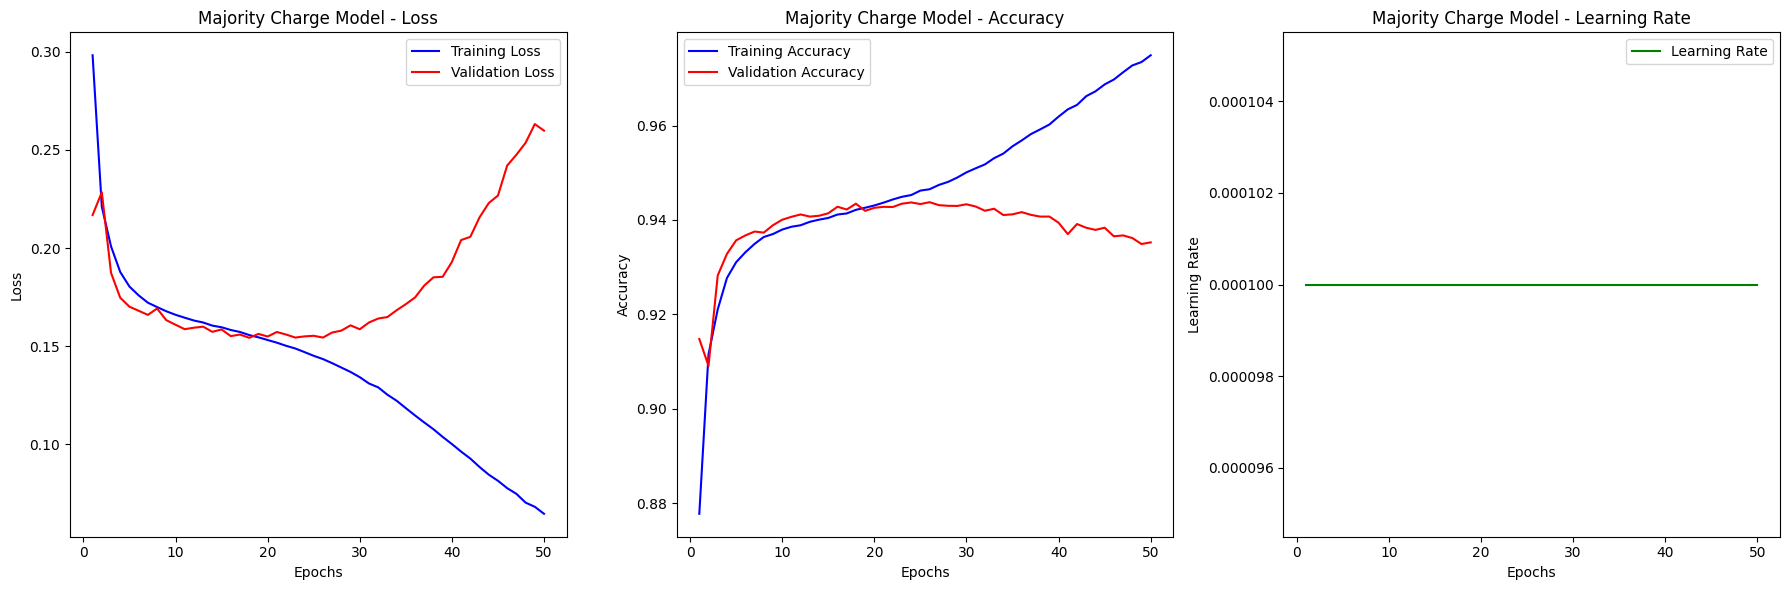

In [59]:
plot_learning_curves(majority_charge_model_history, title='Majority Charge Model')

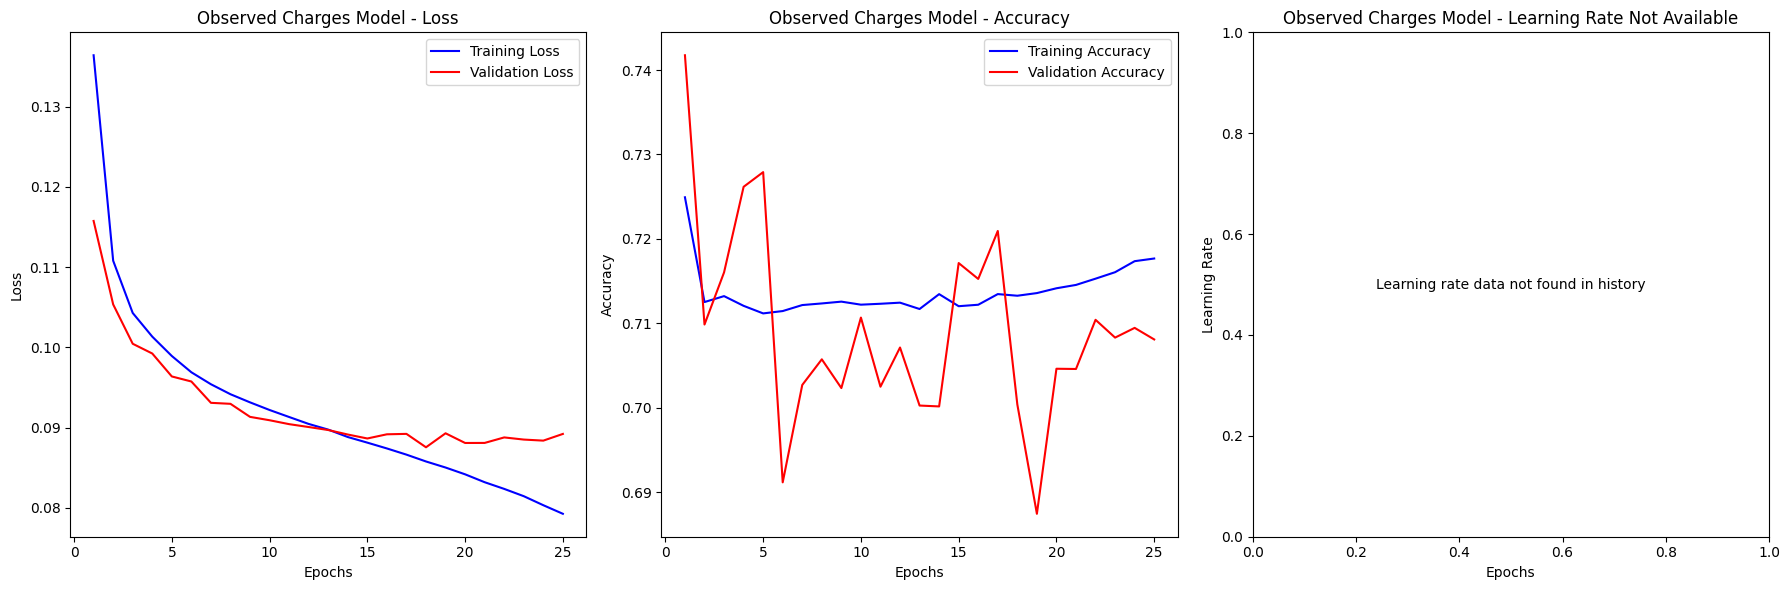

In [167]:
plot_learning_curves(observed_charges_model_history, title='Observed Charges Model')

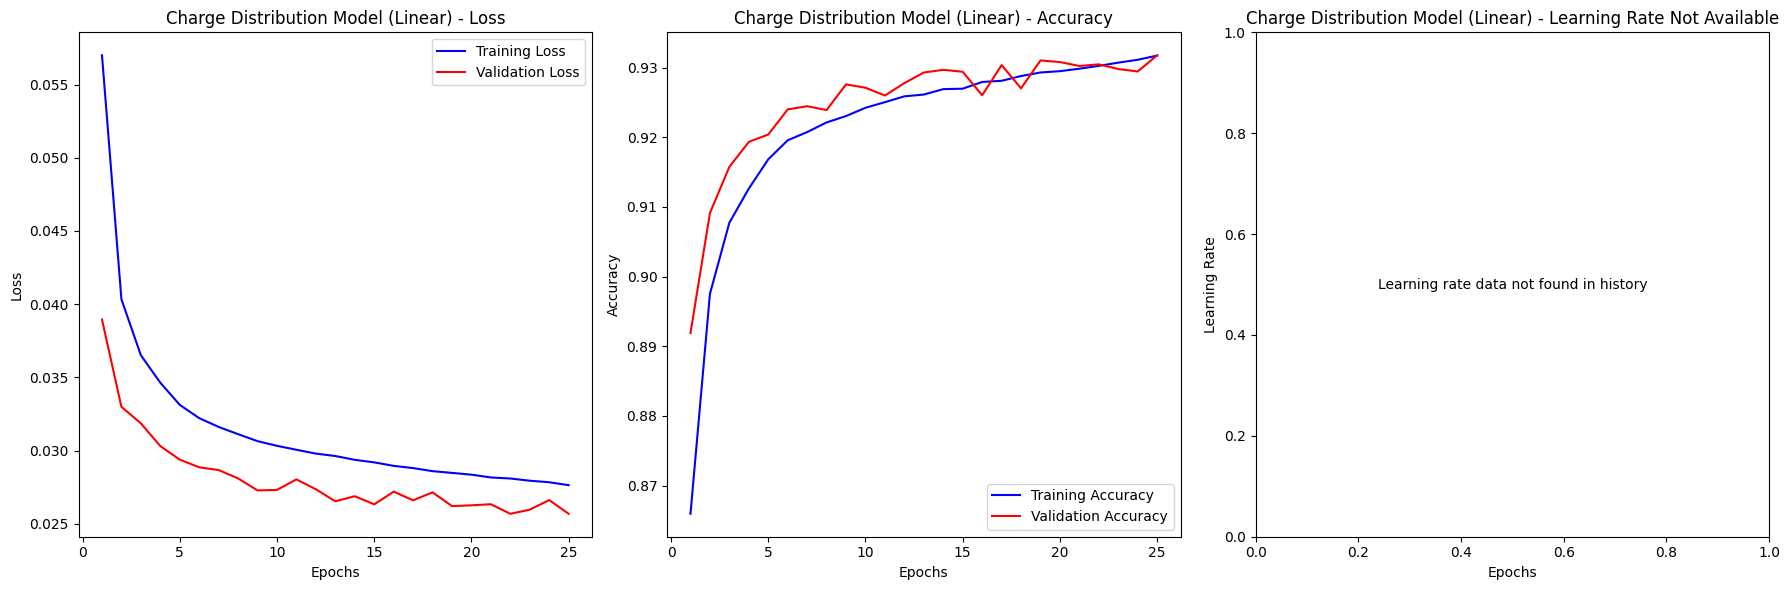

In [24]:
plot_learning_curves(charge_distribution_model_history, title='Charge Distribution Model (Linear)')

In [49]:
def evaluate_model(model, X_test, y_test):
    # Predict classes
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print('#################################')
    print(model.summary())
    print('#################################')
    # Print the classification report
    print(classification_report(y_true, y_pred_classes))
    print('#################################')
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes, normalize='true')
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_true)))
    plt.xticks(tick_marks, np.unique(y_true), rotation=45)
    plt.yticks(tick_marks, np.unique(y_true))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

3324/3324 [==============================] - 3s 1ms/step
#################################
Model: "dominant_charge_state_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  352       
                                                                 
 sequential (Sequential)     (None, 19, 512)           406272    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 sequential_1 (Sequential)   (None, 64)                1253568   
                                                                 
 dense_2 (Dense)             multiple                  390       
                                                                 
Total params: 1660582 (6.33 MB)
Trainable params: 1660582 (6.33 MB)
Non-trai

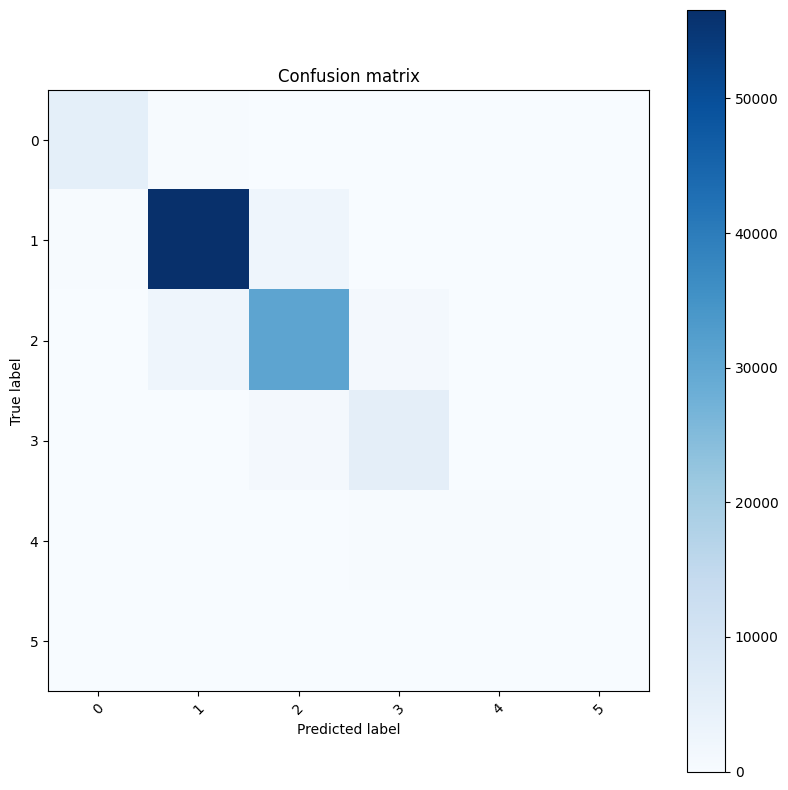

In [48]:
evaluate_model(majority_charge_model, majority_X_test, majority_y_test)